# Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report

import numpy as np
import pandas as pd

rf_distance = RandomForestClassifier(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
df = pd.read_csv('..\\data\\data_cleaned.csv')






# Definisco le variabili feature
features = ['wind_direction', 'concentration', 'U']
target = 'distance'
X = df[features]
# Definisco la variabile target
y = df[target]



In [35]:
#Stampo la distribuzione delle classsi
print(y.value_counts())

distance
50     1081
100     963
200     792
Name: count, dtype: int64


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Faccio la cross-validation del modello
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
print("Cross-validation scores:", cv_scores)

trained_model = model.fit(X_train, y_train)
# Predizioni sul test set
y_test_pred = trained_model.predict(X_test)
# Valuto le prestazioni del modello
accuracy = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", accuracy)
print("Classification report:\n", classification_report(y_test, y_test_pred))

Cross-validation scores: [0.72687225 0.69823789 0.69823789 0.66666667 0.70860927]
Test set accuracy: 0.7147887323943662
Classification report:
               precision    recall  f1-score   support

          50       0.77      0.80      0.79       234
         100       0.59      0.61      0.60       182
         200       0.78      0.70      0.74       152

    accuracy                           0.71       568
   macro avg       0.71      0.71      0.71       568
weighted avg       0.72      0.71      0.71       568



### Matrice di confusione

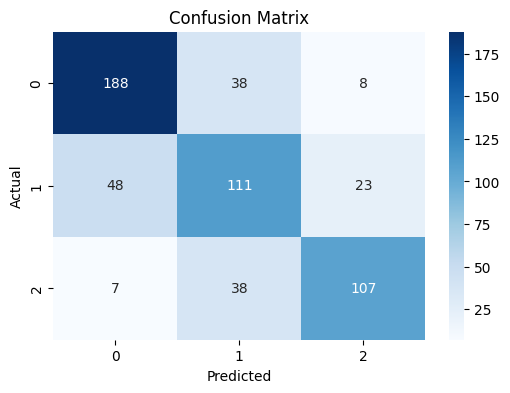

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Curva ROC e AUC

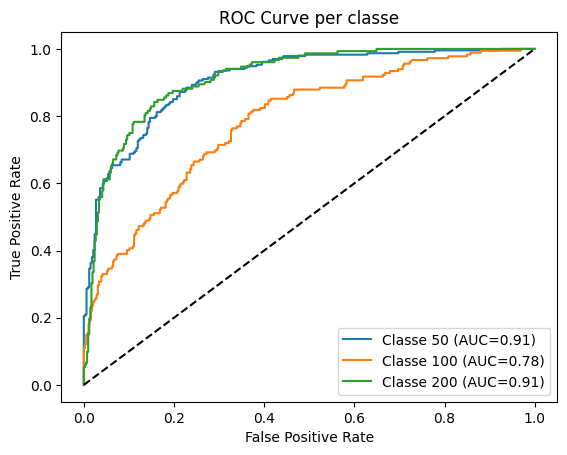

In [38]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = trained_model.predict_proba(X_test)
for i, class_label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Classe {class_label} (AUC={auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per classe')
plt.legend()
plt.show()

### Precision-Recall Curve

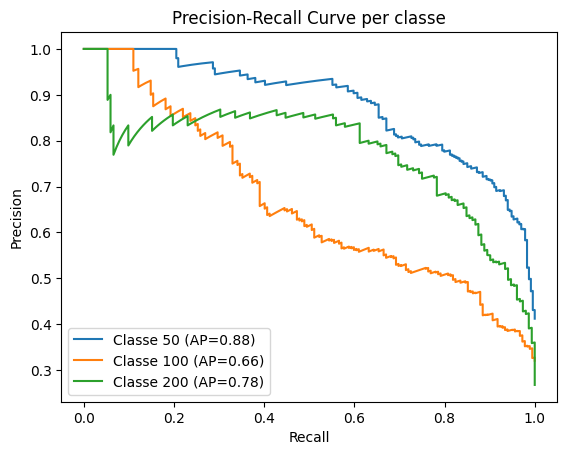

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score

for i, class_label in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f'Classe {class_label} (AP={average_precision_score(y_test_bin[:, i], y_score[:, i]):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per classe')
plt.legend()
plt.show()

### Learning curve

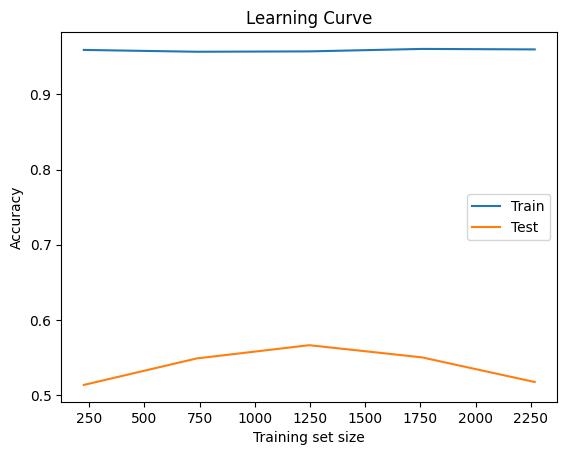

In [40]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(trained_model, X, y, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

### Feature importance

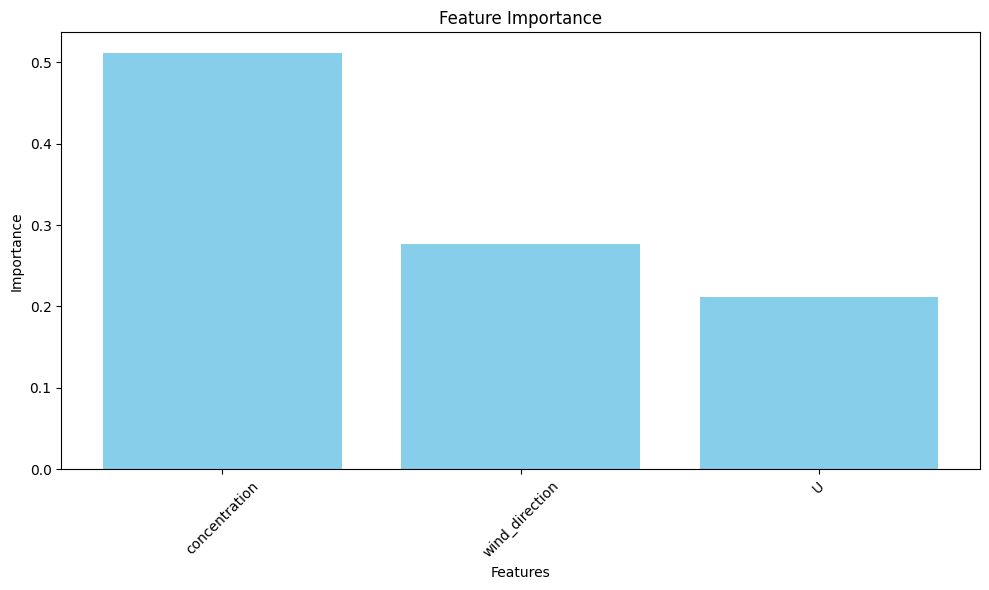

In [41]:


# Feature importance
importances = pd.DataFrame({
    'Feature': features,
    'Importance': trained_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
# Plotto le feature importance
plt.figure(figsize=(10, 6))
plt.bar(importances['Feature'], importances['Importance'], color='skyblue')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
# Metriche di valutazione
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Classification Report:")
print("Accuracy: ", accuracy_score(y_test, y_test_pred))


Classification Report:
Accuracy:  0.7147887323943662


In [43]:
# Predizione su nuovi dati
def predict_distance( wind_direction, concentration, Wind_Speed):
    new_sample = pd.DataFrame([[ wind_direction, concentration, Wind_Speed]], columns=features)
    prediction = trained_model.predict(new_sample)[0]
    probabilities = trained_model.predict_proba(new_sample)[0]
    print(f"Predicted distance: {prediction} metri")
    print(f"Probabilities per classe:")
    for i, prob in enumerate(probabilities):
        print(f"Classe {i} m: {prob:.2f}")
    return prediction

In [44]:
# Esempio di predizione
predict_distance( wind_direction=45, concentration=5, Wind_Speed=10)


Predicted distance: 100 metri
Probabilities per classe:
Classe 0 m: 0.44
Classe 1 m: 0.52
Classe 2 m: 0.04


np.int64(100)

In [45]:
# Ottimizzazione del modello
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],

}

grid_search = GridSearchCV(estimator=trained_model, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best cross-validation score:  0.6997247911621981


In [46]:
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_test_pred = best_rf.predict(X_test)
print("Classification report for best model:\n", classification_report(y_test, y_test_pred))

Classification report for best model:
               precision    recall  f1-score   support

          50       0.77      0.80      0.79       234
         100       0.59      0.61      0.60       182
         200       0.78      0.70      0.74       152

    accuracy                           0.71       568
   macro avg       0.71      0.71      0.71       568
weighted avg       0.72      0.71      0.71       568



In [47]:
#Cambio train e test set

df_train_test = pd.read_csv('..\\data\\data2_model_before_parsing.csv')
df_val = pd.read_csv('..\\data\\data1_model_before_parsing.csv')

In [48]:
#Splitto il df_train_test
train_df, test_df = train_test_split(df_train_test, test_size=0.2, random_state=42)

#Cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf, train_df[features], train_df[target], cv=kf, scoring='accuracy')
print("Cross-validation scores for best model:", cv_scores)
print("Mean cross-validation score for best model:", cv_scores.mean())

#Fitto il modello
best_rf.fit(train_df[features], train_df[target])
# Predizioni sul test set
predictions = best_rf.predict(test_df[features])
# Determino la predizione sul validation set
val_predictions = best_rf.predict(df_val[features])
# Valuto le prestazioni del modello sul test set
y_val = df_val[target]

#1. Accuracy
accuracy_val = accuracy_score(val_predictions, y_val)
print("Validation set accuracy:", accuracy_val)


Cross-validation scores for best model: [0.79651163 0.80232558 0.80813953 0.80116959 0.78362573]
Mean cross-validation score for best model: 0.7983544131646947
Validation set accuracy: 0.35961429381735677


In [49]:

#2. Classification report
print("Classification report for validation set:\n", classification_report(y_val, val_predictions))


Classification report for validation set:
               precision    recall  f1-score   support

          50       0.64      0.16      0.26       675
         100       0.28      0.26      0.27       594
         200       0.36      0.74      0.48       494

    accuracy                           0.36      1763
   macro avg       0.43      0.39      0.34      1763
weighted avg       0.44      0.36      0.33      1763



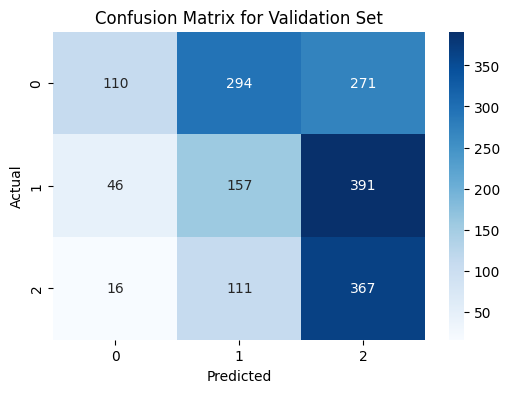

In [50]:

#3. Confusion matrix
cm_val = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Validation Set')
plt.show()



## Random Forest for Azimuth prediction

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

target_azimuth = 'azimuth'
X = df[features]
y_azimuth = df[target_azimuth]

X_train_azimuth, X_test_azimuth, y_train_azimuth, y_test_azimuth = train_test_split(X, y_azimuth, test_size=0.2, random_state=42)

rf_azimuth = RandomForestRegressor(random_state=42)
rf_azimuth.fit(X_train_azimuth, y_train_azimuth)

# Predizioni sul test set per l'azimuth
y_test_pred_azimuth = rf_azimuth.predict(X_test_azimuth)

# Valuto le prestazioni del modello per l'azimuth
mse = mean_squared_error(y_test_azimuth, y_test_pred_azimuth)
print("Test set MSE for azimuth:", mse)
print("R^2 score for azimuth:", rf_azimuth.score(X_test_azimuth, y_test_azimuth))


Test set MSE for azimuth: 438.287586437006
R^2 score for azimuth: 0.5963019571909045


In [55]:
from sklearn.metrics import explained_variance_score
evs = explained_variance_score(y_test_azimuth, y_test_pred_azimuth)
print("Explained Variance Score:", evs)

Explained Variance Score: 0.5964549671421144


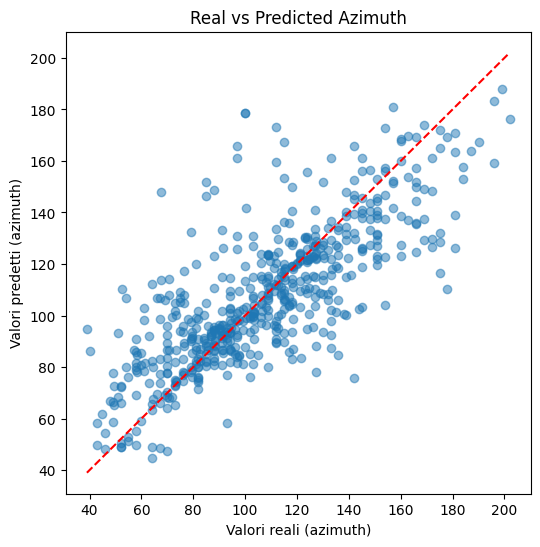

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_azimuth, y_test_pred_azimuth, alpha=0.5)
plt.plot([y_test_azimuth.min(), y_test_azimuth.max()], [y_test_azimuth.min(), y_test_azimuth.max()], 'r--')
plt.xlabel('Valori reali (azimuth)')
plt.ylabel('Valori predetti (azimuth)')
plt.title('Real vs Predicted Azimuth Not optimized')
plt.show()

In [57]:
#ottimizzazione del modello per l'azimuth
param_grid_azimuth = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search_azimuth = GridSearchCV(estimator=rf_azimuth, param_grid=param_grid_azimuth, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_azimuth.fit(X_train_azimuth, y_train_azimuth)
print("Best parameters for azimuth model found: ", grid_search_azimuth.best_params_)


Best parameters for azimuth model found:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [58]:
# Predizione con il modello ottimizzato
best_rf_azimuth = grid_search_azimuth.best_estimator_
best_rf_azimuth.fit(X_train_azimuth, y_train_azimuth)
y_test_pred_azimuth = best_rf_azimuth.predict(X_test_azimuth)

In [61]:
#Valuto le prestazioni del modello ottimizzato per l'azimuth
mse_optimized = mean_squared_error(y_test_azimuth, y_test_pred_azimuth)
print("Test set MSE for optimized azimuth model:", mse_optimized)
print("R^2 score for optimized azimuth model:", best_rf_azimuth.score(X_test_azimuth, y_test_azimuth))

Test set MSE for optimized azimuth model: 418.9645648809198
R^2 score for optimized azimuth model: 0.6141000108541722


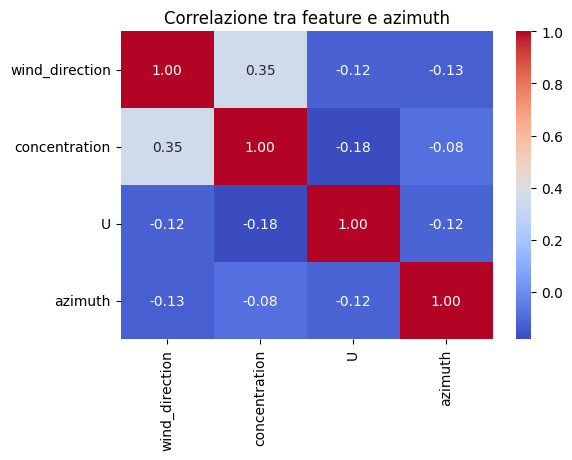

In [63]:

# Unisci le feature e l'azimuth in un unico DataFrame
df_corr = df[features + ['azimuth']]

# Calcola la matrice di correlazione
corr_matrix = df_corr.corr()

# Plotta la heatmap delle correlazioni
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlazione tra feature e azimuth')
plt.show()